# Variational Quantum Classifier #

## MITP 2023

In this notebook we will consider the Variational Quantum Classifier (VQC) which is a hybrid classical-quantum computing approach to classification problems. The algorithm uses the variational method to optimise a parameterised quantum circuit and minimise a loss function. Comparing to a classical classification problem, the VQC is very similar, but one replaces the classical model with a quantum circuit. 

Here we will consider a simple VQC, using the Titanic dataset from the [Kaggle competition](https://www.kaggle.com/c/titanic). We will code the algorithm in the `PennyLane` language (See the Introduction to Quantum Computing notebook for help), making use of the inbuilt `AdamOptimiser`. For the classical processing, we will use the `sklearn` package. We will also use `Pandas` `DataFrames`, if you are not familiar, there is a good introduction [here](https://www.w3schools.com/python/pandas/pandas_intro.asp).

In [17]:
import pennylane as qml
import pandas as pd
import math

import matplotlib.pyplot as plt

from pennylane import numpy as npl
from pennylane.optimize import AdamOptimizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

### Set up device
n_qubits = 4
n_layers = 2
dev      = qml.device("default.qubit", wires = n_qubits)

# Titanic Classification Problem 

The Titanic classification problem takes passenger data from the Titanic and predicts which passengers survived the sinking of the Titanic. The data consists of personal data of each passenger, for example their name, age, gender, socio-economic class etc. Try using a `Pandas` `DataFrame` to examine the full dataset in the `train.csv` file.  

In [2]:
### Your Pandas code here
train = pd.read_csv("./TitanicData/train.csv")
test  = pd.read_csv("./TitanicData/test.csv")

In [3]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


For this VQC example we will choose variables which we know will allow for the algorithm to perform well, namely:

- `is_child` (i.e. under 12 years old)
- `Pclass_1` (Passenger in first class)
- `Pclass_2` (Passenger in second class)
- `Sex_female` (Passenger is a woman)

We have chosen these variables because we know that children and women from the higher classes had a better survival rate on the Titanic. 

Having defined our problem, we are now ready to construct the VQC.


## Constructing the VQC

### Data Embedding

To construct a VQC one needs to embed a parameterised quantum circuit into the classical classifier toolchain. As quantum computers work in a different paradigm from classical computers, this is more complicated than simply replacing the classical model with a quantum model. To adjust from classical data to quantum data, the quantum part of the algorithm therefore must contain a data encoding stage, often called the 'feature map' stage. Introductions to feature mapping and data encoding are available from Pennylane [here](https://pennylane.ai/qml/glossary/quantum_feature_map) and [here](https://pennylane.ai/qml/glossary/quantum_embedding). Qiskit also has a [quantum machine learning package](https://qiskit.org/ecosystem/machine-learning/) which can be used for similar examples.

Since we have only four variables, which are all Booleans, we can use a very simple embedding, *Basis Embedding*. Basis embedding associates each input with a computational basis state of a qubit system. Thus, we can encode the Booleans as $\vert 0 \rangle$ for `False` and $\vert 1 \rangle$ for `True`. Thus, if a passenger is a female child who is in first class, the embedding would take the form 

$$
1101\rightarrow \vert 1101 \rangle.
$$

We use the `BasisEmbedding` from Pennylane.

In [5]:
def dataEmbedding(x):
    qml.BasisEmbedding(x, wires=range(0, n_qubits))

### Constructing the model

Now that we have encoded the data onto the device, we can now build out model (also known as the ansatz). For the VQC, the model is a parameterised quantum circuit with a set of features which can be trained and updated by the optimiser. When constructing a suitable model, one needs to consider two circuit characteristics:

- Expressibility: We define expressibility as a circuit’s ability to generate (pure) states that are well representative of the Hilbert space.
- Entanglement: How entangled the system is.

More information on calculating the expressibility and entanglement of a circuit is available in this [paper](https://arxiv.org/abs/1905.10876).

A single Layer of the chosen model has the form (note, here we use qiskit only for its circuit visualisation)

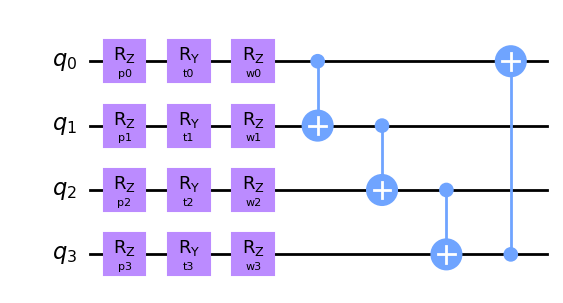

In [6]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.visualization import *

qc = QuantumCircuit(4)
for i in range(4):
    qc.rz(Parameter("p%i" %i), i)
    qc.ry(Parameter("t%i" %(i)), i)
    qc.rz(Parameter("w%i" %(i)), i)

for i in range(3):
    qc.cx(i, i+1)
qc.cx(3, 0)
    
qc.draw('mpl')

In Pennylane we build the layer using the `qml.Rot` which has the form 

$$
R(\phi, \theta, \omega) = RZ(\omega) RY(\theta) RZ(\phi) = \begin{pmatrix} e^{-i(\phi+\omega)/2} \cos(\theta/2) & -e^{i(\phi-\omega)/2} \sin(\theta/2) \\ e^{-i(\phi-\omega)/2} \sin(\theta/2) & e^{i(\phi+\omega)/2} \cos(\theta/2) \end{pmatrix}.
$$

and thus the Layer can be built easily using Pennylane

In [7]:
def layer(W):
    
    for i in range(n_qubits):
        qml.Rot(W[i,0], W[i,1], W[i,2], wires=i)
        
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i, i+1])
    qml.CNOT(wires=[n_qubits-1, 0])

The expressibility of the circuit is introduced through the initial rotations in the Layer, which are parameterised RZ, RY and RZ rotations, the angles of which will be adjusted by the classical optimiser. These rotations construct a superposition of the compuational basis on each of the circuits individually.

The circuit is then entangled with the series of `CNOT` gate operations. 

The Layer can then be applied iteratively, increasing the number of features in the model. The subsequent applications of the Layer increases the expressibility and entanglement of the circuit. However, there are several things that must be considered when deciding how many iterations to apply. Firstly, from a more conventional stance, one does not want to over train by having too many parameters. Therefore, finding a good amount of layers wihtout overtraining is important. Secondly, from a quantum point of view, more iterations result in deeper circuits. In the Noisy Intermediate-Scale Quantum (NISQ) era, circuit depth is one of the most important factors contributing to the fidelity of the results from the device. The deeper the circuit, the more susceptable the circuit becomes to noise. See this [paper](https://arxiv.org/abs/1905.10876) for more information. 

### Building the circuit

We are now ready to build the full circuit, including the data embedding stage and the iterative application of the Layers. 

Here we "borrow" the Machine Learning term weights for the parameters of the rotations.

In [8]:
@qml.qnode(dev, interface="autograd")
def circuitBuild(weights, x):
    
    dataEmbedding(x)
    
    for W in weights:
        layer(W)
        
    return qml.expval(qml.PauliZ(0))

In [10]:
qml.drawer.use_style('sketch')

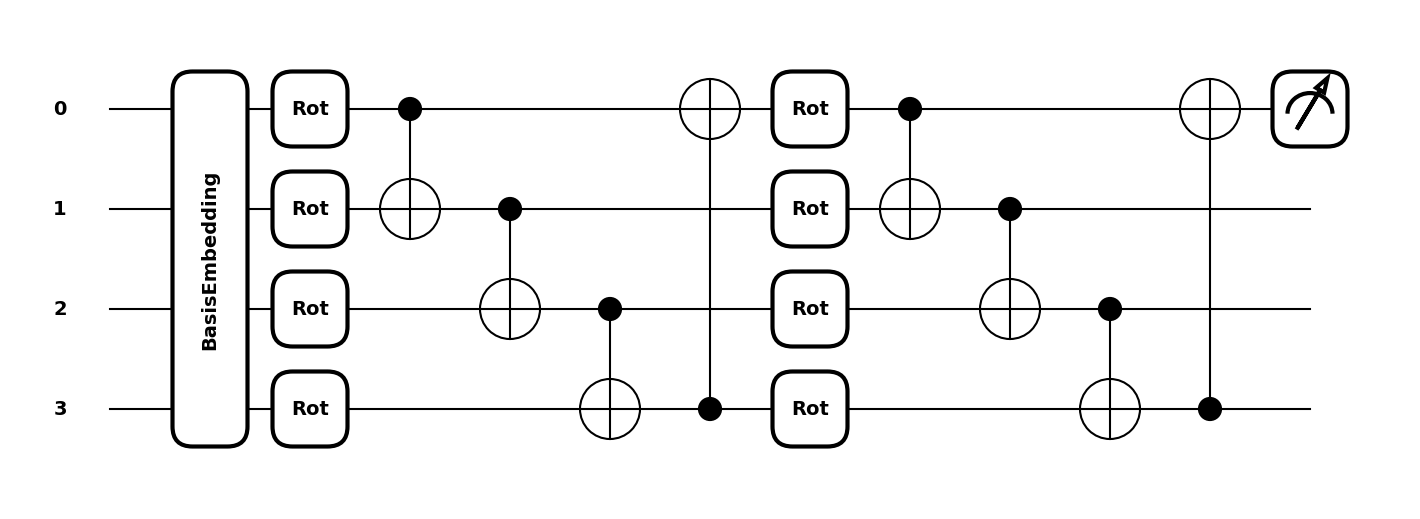

In [20]:
qml.draw_mpl(circuitBuild)([npl.zeros((n_qubits,3))]*n_layers, npl.zeros(n_qubits))
plt.show()

Let us now assume we want to add a classical bias parameter. We add this to the VQC by defining a final model with a classical node that uses the first variable and then feeds the rest into the quantum node. Before this, we reshape the list of remaining variables for easy use in the quantum node.

In [21]:
def variational_classifier(weights, bias, x):
    return circuitBuild(weights, x) + bias

### Cost

In supervised learning, the cost function is often the sum of the loss function and a regulariser. We will do the same here and use standard square loss. 

In [22]:
def squareLoss(labels, predictions):
    
    loss = 0
    
    for l, p in zip(labels, predictions):
        loss = loss + (l-p)**2
        
    loss = loss/len(labels)
    
    return loss

To keep track of how well the model is performing, we also define the accuracy given the target labels and model predictions.

In [23]:
def accuracy(labels, predictions):
    
    loss = 0
    
    for l, p in zip(labels, predictions):
        if abs(l-p) < 1e-5:
            loss = loss + 1
    
    loss = loss/len(labels)
        
    return loss

The cost will depend on the data, which here are the features and labels considered in the current iteration of the optimisation.

In [24]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return squareLoss(Y, predictions)

### Optimisation

We are now ready to perform the training of the model for our Titanic classification problem. Here we prepare and process the data from the Titanic `train.csv` data set. 

In [25]:
### Read in file
# train = pd.read_csv('TitanicData/train.csv')

# change data type to a string
train['Pclass'] = train['Pclass'].astype(str)

# Add columns with Boolean type values for chosen variables
train = pd.concat([train, pd.get_dummies(train[['Pclass', 'Sex', 'Embarked']])], axis=1)

The dataset is not complete, and some ages are missing. So we fix the missing ages with the median age, and a value between 0 and 11 for children.

In [26]:
train['Age'] = train['Age'].fillna(train['Age'].median())
train['is_child'] = train['Age'].map(lambda x: 1 if x < 12 else 0)

We now use the `train_test_split` from `sklearn` to split our dataset randomly into test and train subsets.  

In [27]:
model_vars = ['is_child', 'Pclass_1', 'Pclass_2', 'Sex_female']
X_train, X_test, y_train, y_test = train_test_split(train[model_vars], train['Survived'], 
                                                    test_size=0.10, random_state=42, 
                                                    stratify=train['Survived'])

X_train = npl.array(X_train.values, requires_grad=False)
Y_train = npl.array(y_train.values * 2 - npl.ones(len(y_train)), requires_grad=False)

Here `requires_grad` marks an argument as trainable. More info on the PennyLane NumPy interface is available [here](https://docs.pennylane.ai/en/stable/introduction/interfaces/numpy.html). 

Now we have prepared the data, we can optimise the rotation parameters of the model using the `AdamOptimizer`.

In [28]:
### Set initial parameters
npl.random.seed(0)
weights_init = 0.01 * npl.random.randn(n_layers, n_qubits, 3, requires_grad=True)
bias_init    = npl.array(0.0, requires_grad=True)

In [29]:
opt        = AdamOptimizer(0.125)                 # Set appropriate learning rate for Adam
n_it       = 35                                   # Number of iterations
batch_size = math.floor(len(X_train)/n_it)        # Determine batch size

In [30]:
weights = weights_init
bias    = bias_init

### Run Optimisation

for it in range(n_it):

    # Update trainable arguments with one step of the optimizer.                                                                                                                                   
    batch_index         = npl.random.randint(0, len(X_train), (batch_size,))
    X_batch             = X_train[batch_index]
    Y_batch             = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute accuracy                                                                                                                                                            
    predictions         = [npl.sign(variational_classifier(weights, bias, x)) for x in X_train]
    acc                 = accuracy(Y_train, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X_train, Y_train), acc
        )
    )

Iter:     1 | Cost: 2.3009047 | Accuracy: 0.3657928 
Iter:     2 | Cost: 2.0069723 | Accuracy: 0.3657928 
Iter:     3 | Cost: 1.6768622 | Accuracy: 0.3657928 
Iter:     4 | Cost: 1.4171261 | Accuracy: 0.5255930 
Iter:     5 | Cost: 1.2510112 | Accuracy: 0.6167291 
Iter:     6 | Cost: 1.1688063 | Accuracy: 0.6167291 
Iter:     7 | Cost: 1.1336431 | Accuracy: 0.6167291 
Iter:     8 | Cost: 1.0991138 | Accuracy: 0.6167291 
Iter:     9 | Cost: 1.0469797 | Accuracy: 0.6167291 
Iter:    10 | Cost: 0.9871259 | Accuracy: 0.6167291 
Iter:    11 | Cost: 0.9374590 | Accuracy: 0.6167291 
Iter:    12 | Cost: 0.8986214 | Accuracy: 0.6167291 
Iter:    13 | Cost: 0.8667102 | Accuracy: 0.6779026 
Iter:    14 | Cost: 0.8460376 | Accuracy: 0.7802747 
Iter:    15 | Cost: 0.8202597 | Accuracy: 0.7802747 
Iter:    16 | Cost: 0.7953863 | Accuracy: 0.7802747 
Iter:    17 | Cost: 0.7581353 | Accuracy: 0.7802747 
Iter:    18 | Cost: 0.7289362 | Accuracy: 0.7802747 
Iter:    19 | Cost: 0.7101794 | Accuracy: 0.78

In [31]:
X_test = npl.array(X_test.values, requires_grad=False)
Y_test = npl.array(y_test.values * 2 - npl.ones(len(y_test)), requires_grad=False)

predictions = [npl.sign(variational_classifier(weights, bias, x)) for x in X_test]

### Test model
accuracy_score(Y_test, predictions)
precision_score(Y_test, predictions)
recall_score(Y_test, predictions)
f1_score(Y_test, predictions, average='macro')

0.7712374581939799

## Exercise: Modify your VQC

We see that the model performs well, reaching an accuracy close to 80%. It is interesting to investigate the affect of different parts of the VQC. Below, try using a different model quantum circuit (see this [paper](https://arxiv.org/abs/1905.10876) for inspiration!) with different expressibility and entanglement. How does the model effect the training and accuracy?

In [ ]:
@qml.qnode(dev, interface="autograd")
def new_circuitBuild(weights, x):
    
    ###
    ### Your code here
    ###
        
    return qml.expval(qml.PauliZ(0))

Currently, the measurement returns the expectation value of the `PauliZ` observable on wire 0. Do you kno why we do this? How does changing the measurement affect the model?

In [ ]:
@qml.qnode(dev, interface="autograd")
def new_circuitBuild(weights, x):
    
    ###
    ### Your code here
    ###
        
    return ### How does the measurement effect the system?